=== Итоговые метрики моделей ===
  Model        R2       MSE
0   GBM  0.465438  0.394799
1   SVR  0.373956  0.462363
2   MLP  0.360015  0.472659


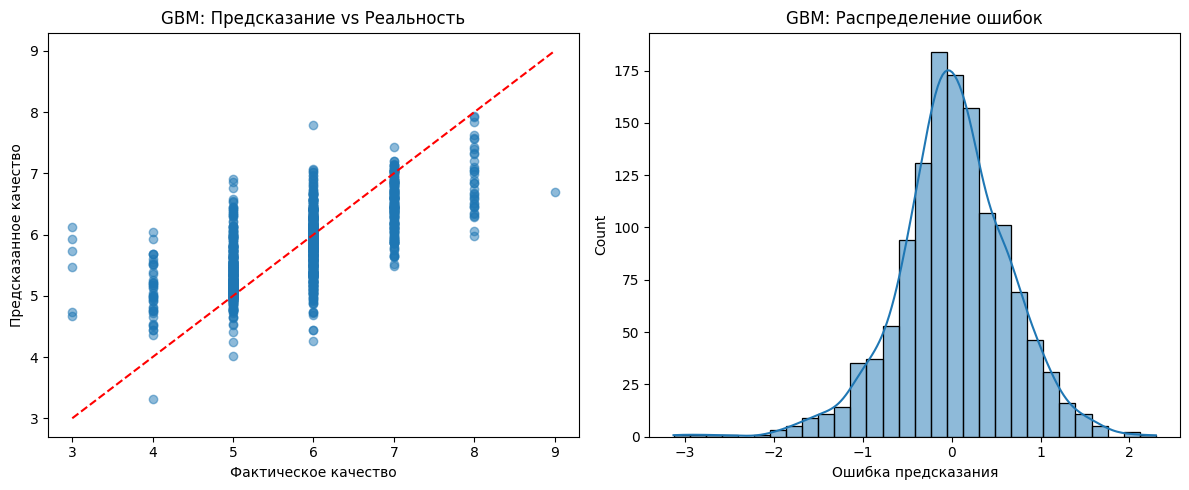

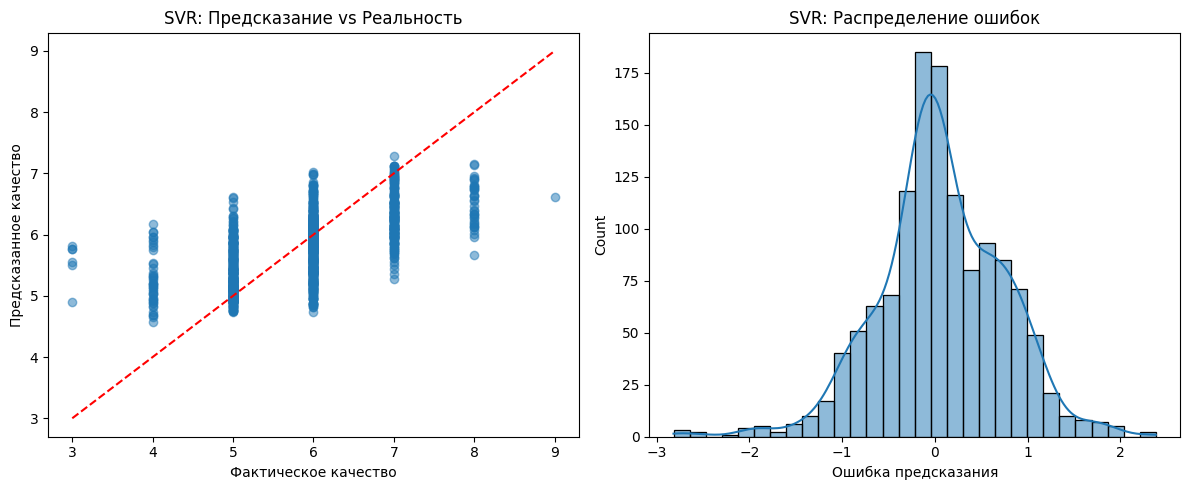

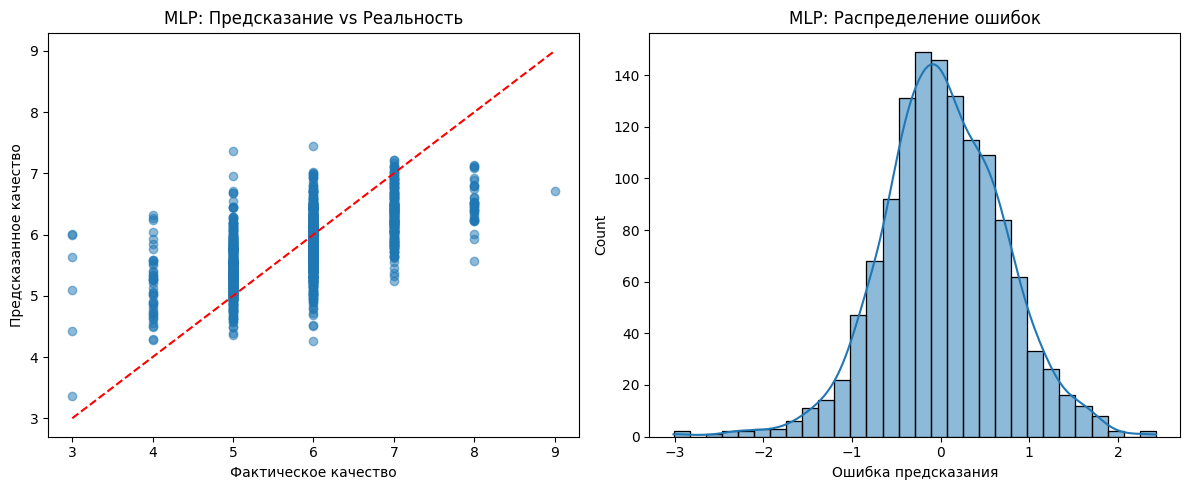

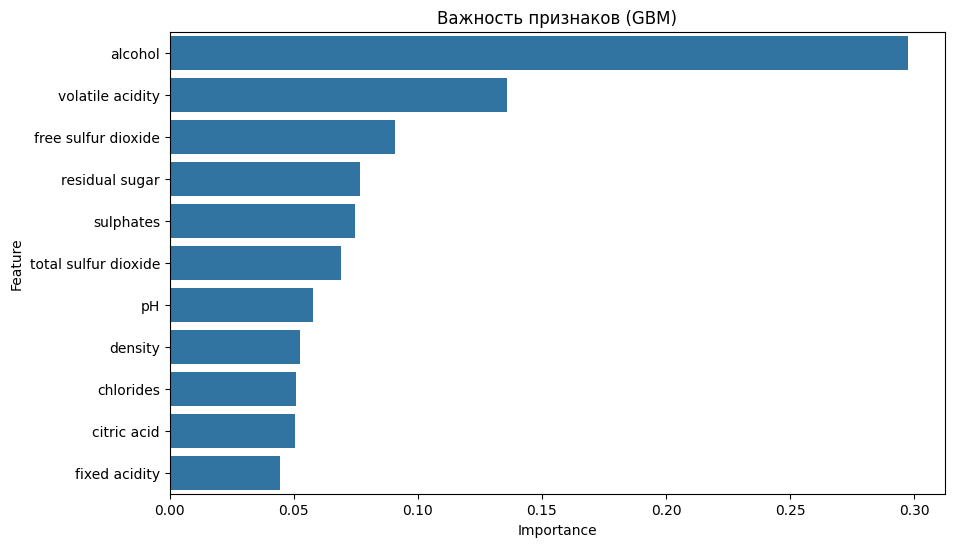

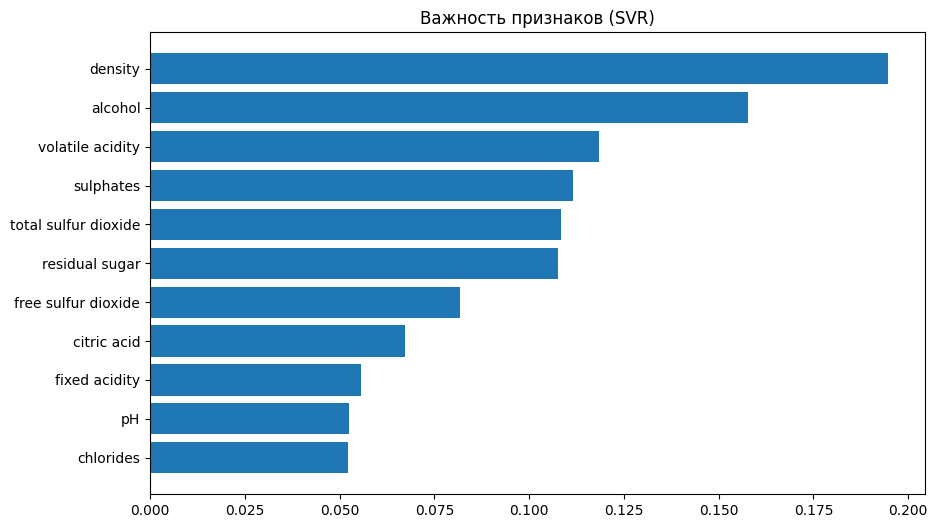

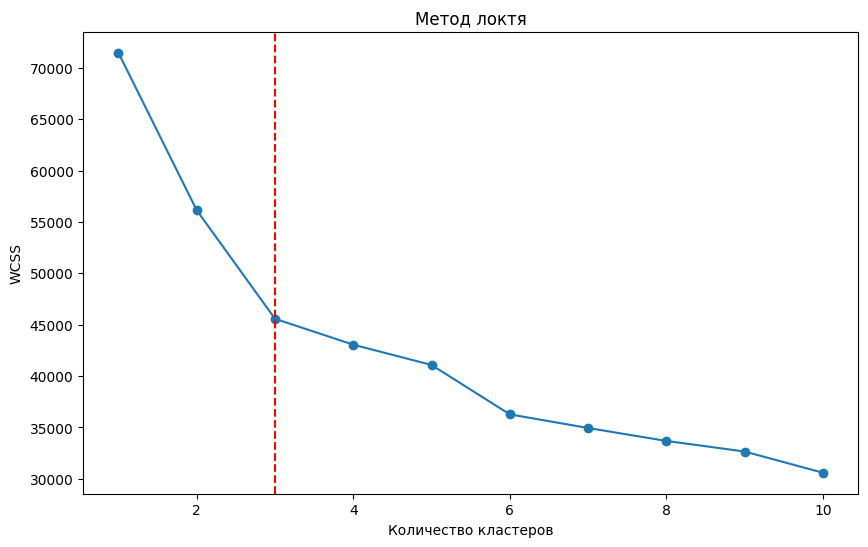

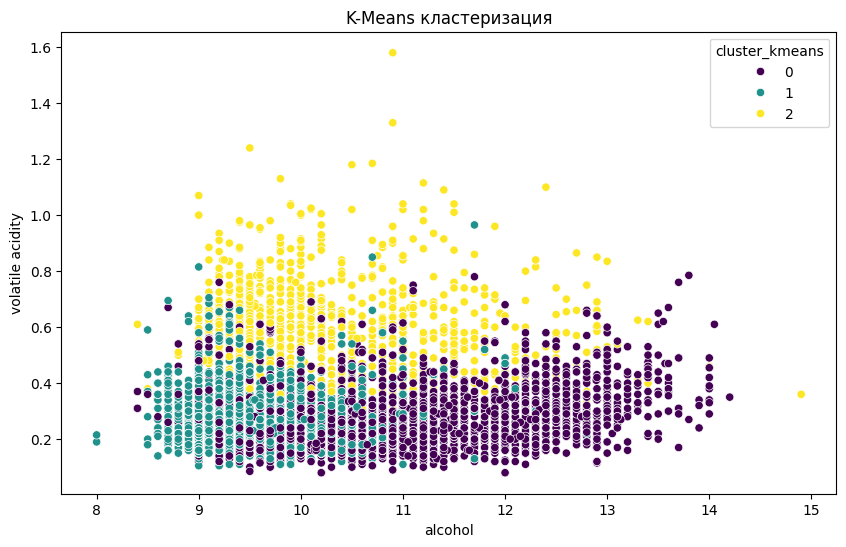

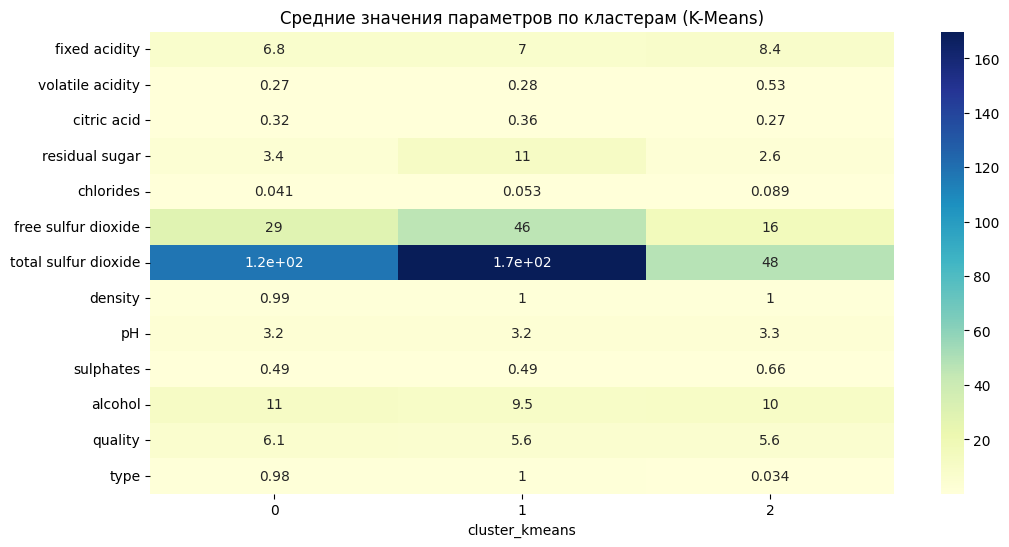

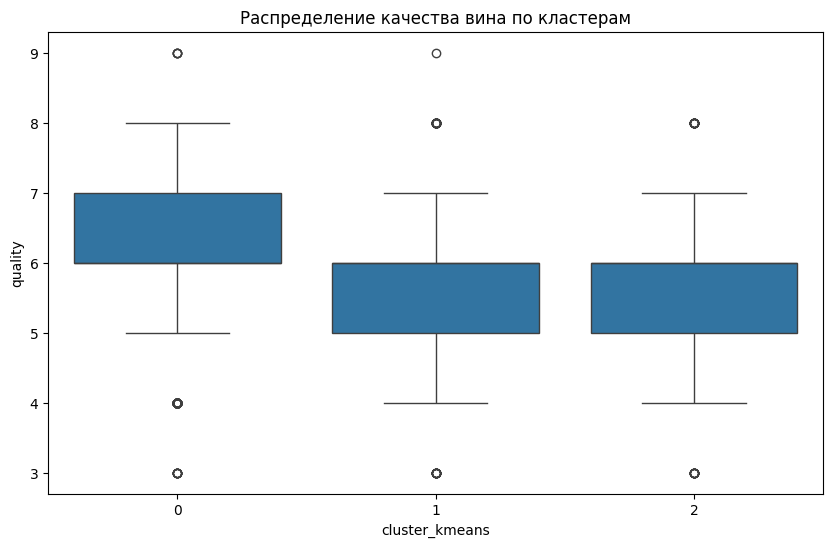

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import warnings
import sys
from io import StringIO

warnings.filterwarnings("ignore")

zip_path = 'archive10.zip'
extract_path = 'wine_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Загрузка CSV
red = pd.read_csv(os.path.join(extract_path, 'winequality-red.csv'), sep=';')
white = pd.read_csv(os.path.join(extract_path, 'winequality-white.csv'), sep=';')
red['type'] = 0
white['type'] = 1
wine = pd.concat([red, white])

X = wine.drop(['quality', 'type'], axis=1)
y = wine['quality']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование
scaler_robust = RobustScaler()
X_train_scaled = scaler_robust.fit_transform(X_train)
X_test_scaled = scaler_robust.transform(X_test)

# -----------------------------
# GBM
gbm = GradientBoostingRegressor(random_state=42)
gbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5]
}
gbm_grid = GridSearchCV(gbm, gbm_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
gbm_grid.fit(X_train, y_train)
best_gbm = gbm_grid.best_estimator_

# -----------------------------
# SVR
svr = SVR(kernel='rbf')
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']
}
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
svr_grid.fit(X_train_scaled, y_train)
best_svr = svr_grid.best_estimator_

# -----------------------------
# MLP - 
old_stderr = sys.stderr
sys.stderr = StringIO()

try:
    mlp = MLPRegressor(
        hidden_layer_sizes=(100,50), 
        early_stopping=True, 
        random_state=42,
        max_iter=1000,  
        tol=1e-4        
    )
    mlp_params = {
        'hidden_layer_sizes': [(50,), (100,50), (100,100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'max_iter': [1000]  
    }
    mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    mlp_grid.fit(X_train_scaled, y_train)
    best_mlp = mlp_grid.best_estimator_
finally:
    sys.stderr = old_stderr  

# -----------------------------
# Предсказания и сбор результатов
results = []
models = {'GBM': best_gbm, 'SVR': best_svr, 'MLP': best_mlp}

for name, model in models.items():
    if name == 'GBM':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)
    results.append({
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred)
    })

# Итоговая таблица
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("=== Итоговые метрики моделей ===")
print(results_df)

# -----------------------------
# Визуализация результатов
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Фактическое качество')
    plt.ylabel('Предсказанное качество')
    plt.title(f'{model_name}: Предсказание vs Реальность')

    plt.subplot(1,2,2)
    errors = y_true - y_pred
    sns.histplot(errors, bins=30, kde=True)
    plt.title(f'{model_name}: Распределение ошибок')
    plt.xlabel('Ошибка предсказания')

    plt.tight_layout()
    plt.show()

# GBM
plot_results(y_test, best_gbm.predict(X_test), "GBM")
# SVR
plot_results(y_test, best_svr.predict(X_test_scaled), "SVR")
# MLP
plot_results(y_test, best_mlp.predict(X_test_scaled), "MLP")

# -----------------------------
# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_gbm.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков (GBM)')
plt.show()

perm_importance = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=10)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Важность признаков (SVR)")
plt.show()

# -----------------------------
# KMeans кластеризация
scaler_std = StandardScaler()
X_scaled = scaler_std.fit_transform(X)

# Метод локтя
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.axvline(x=3, color='r', linestyle='--')
plt.show()

# KMeans с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42)
wine['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(10,6))
sns.scatterplot(x='alcohol', y='volatile acidity', hue='cluster_kmeans',
                data=wine, palette='viridis')
plt.title('K-Means кластеризация')
plt.show()

# Средние значения по кластерам
cluster_stats = wine.groupby('cluster_kmeans').mean()
plt.figure(figsize=(12,6))
sns.heatmap(cluster_stats.T, cmap='YlGnBu', annot=True)
plt.title('Средние значения параметров по кластерам (K-Means)')
plt.show()

# Распределение качества по кластерам
plt.figure(figsize=(10,6))
sns.boxplot(x='cluster_kmeans', y='quality', data=wine)
plt.title('Распределение качества вина по кластерам')
plt.show()


In [15]:
# from sklearn.decomposition import PCA
# X = wine.drop(['quality', 'type'], axis=1)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # В DataFrame для удобства
# pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# kmeans_pca = KMeans(n_clusters=3, random_state=42)
# clusters_pca = kmeans_pca.fit_predict(X_pca)

# pca_df['cluster'] = clusters_pca

# import plotly.express as px

# fig = px.scatter(pca_df, x='PC1', y='PC2', color='cluster',
#                  title='Кластеризация KMeans на PCA-пространстве (2D)',
#                  color_continuous_scale='Viridis')
# fig.show()

# pca_3d = PCA(n_components=3)
# X_pca_3d = pca_3d.fit_transform(X_scaled)

# pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# kmeans_pca_3d = KMeans(n_clusters=3, random_state=42)
# clusters_pca_3d = kmeans_pca_3d.fit_predict(X_pca_3d)

# pca_3d_df['cluster'] = clusters_pca_3d

# fig_3d = px.scatter_3d(pca_3d_df, x='PC1', y='PC2', z='PC3', color='cluster',
#                        title='Кластеризация KMeans на PCA-пространстве (3D)',
#                        color_continuous_scale='Viridis')
# fig_3d.show()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import plotly.express as px
import os

# Создаем папку для графиков
os.makedirs('plots', exist_ok=True)

# Признаки для PCA
X = wine.drop(['quality', 'type'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------- 2D PCA -----------------
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])

print(f'Explained variance ratio (2D): {pca_2d.explained_variance_ratio_}')

# KMeans на 2D PCA
kmeans_2d = KMeans(n_clusters=3, random_state=42)
pca_df['cluster'] = kmeans_2d.fit_predict(X_pca_2d)

# Создаем интерактивный график и сохраняем
fig_2d = px.scatter(pca_df, x='PC1', y='PC2', color='cluster',
                    title='Кластеризация KMeans на PCA-пространстве (2D)',
                    color_continuous_scale='Viridis')
fig_2d.write_html('plots/pca_2d_clusters.html')
print("2D PCA-график сохранен в plots/pca_2d_clusters.html")

# ----------------- 3D PCA -----------------
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

kmeans_3d = KMeans(n_clusters=3, random_state=42)
pca_3d_df['cluster'] = kmeans_3d.fit_predict(X_pca_3d)

# Сохраняем 3D график
fig_3d = px.scatter_3d(pca_3d_df, x='PC1', y='PC2', z='PC3', color='cluster',
                       title='Кластеризация KMeans на PCA-пространстве (3D)',
                       color_continuous_scale='Viridis')
fig_3d.write_html('plots/pca_3d_clusters.html')
print("3D PCA-график сохранен в plots/pca_3d_clusters.html")


Explained variance ratio (2D): [0.29562335 0.2264233 ]
2D PCA-график сохранен в plots/pca_2d_clusters.html
3D PCA-график сохранен в plots/pca_3d_clusters.html


In [ ]:
from sklearn.ensemble import IsolationForest

red_wine = wine[wine['type'] == 0].copy()
white_wine = wine[wine['type'] == 1].copy()

def find_anomalies(data, contamination=0.05):
    clf = IsolationForest(contamination=contamination, random_state=42)
    anomalies = clf.fit_predict(data.drop(['quality', 'type', 'cluster_kmeans'], axis=1))
    return data[anomalies == -1]

# Находим аномалии
red_anomalies = find_anomalies(red_wine)
white_anomalies = find_anomalies(white_wine)

print(f"Найдено {len(red_anomalies)} аномальных красных вин")
print(f"Найдено {len(white_anomalies)} аномальных белых вин")

Найдено 80 аномальных красных вин
Найдено 245 аномальных белых вин


In [ ]:
def analyze_anomalies(anomalies, class_name):
    class_mean = wine[wine['type'] == (0 if class_name == 'red' else 1)].mean()
    anomaly_mean = anomalies.mean()
    
    comparison = pd.DataFrame({
        'Class Mean': class_mean,
        'Anomaly Mean': anomaly_mean,
        'Difference': anomaly_mean - class_mean
    })
    
    print(f"\nСравнение аномальных {class_name} вин с классом:")
    display(comparison.sort_values('Difference', key=abs, ascending=False))
    
    return comparison

red_comparison = analyze_anomalies(red_anomalies, 'red')
white_comparison = analyze_anomalies(white_anomalies, 'white')


Сравнение аномальных red вин с классом:


,Class Mean,Anomaly Mean,Difference
total sulfur dioxide,46.467792,88.400000,41.932208
free sulfur dioxide,15.874922,26.106250,10.231328
residual sugar,2.538806,4.506250,1.967444
cluster_kmeans,1.926204,1.525000,-0.401204
sulphates,0.658149,0.906000,0.247851
alcohol,10.422983,10.632083,0.209100
citric acid,0.270976,0.387750,0.116774
pH,3.311113,3.204375,-0.106738
chlorides,0.087467,0.171937,0.084471
fixed acidity,8.319637,8.401250,0.081613



Сравнение аномальных white вин с классом:


,Class Mean,Anomaly Mean,Difference
total sulfur dioxide,138.360657,158.004082,19.643424
free sulfur dioxide,35.308085,40.973469,5.665384
residual sugar,6.391415,9.095306,2.703891
quality,5.877909,5.424490,-0.453420
cluster_kmeans,0.408330,0.800000,0.391670
alcohol,10.514267,10.213197,-0.301070
fixed acidity,6.854788,7.039592,0.184804
volatile acidity,0.278241,0.390041,0.111800
citric acid,0.334192,0.417755,0.083564
pH,3.188267,3.150204,-0.038063
